# Step 0 - Data Aquisition

The common research question that you are to answer is:

How did masking policies change the progression of confirmed COVID-19 cases from February 1, 2020 through October 1, 2021?


### Importing the python packages and data

In [1]:
!pip install ruptures

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
import matplotlib.dates
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
import ruptures

### Import the data

In [3]:
raw_us_cases = pd.read_csv("/content/drive/MyDrive/MS Admission/Washington/GitHub/DataScienceProjects/data-512-project-common-analysis/data/RAW_us_confirmed_cases.csv")
raw_us_deaths = pd.read_csv("/content/drive/MyDrive/MS Admission/Washington/GitHub/DataScienceProjects/data-512-project-common-analysis/data/RAW_us_deaths.csv")
mask_use_by_county = pd.read_csv("/content/drive/MyDrive/MS Admission/Washington/GitHub/DataScienceProjects/data-512-project-common-analysis/data/mask-use-by-county.csv")
#mask_mandates_april_2020_aug_2021 = pd.read_csv("/content/drive/MyDrive/MS Admission/Washington/Human Centered Design/Project/archive/U.S._State_and_Territorial_Public_Mask_Mandates_From_April_10__2020_through_August_15__2021_by_County_by_Day.csv")
mask_mandates_april_2020_aug_2021 = pd.read_csv("/content/drive/MyDrive/MS Admission/Washington/GitHub/DataScienceProjects/data-512-project-common-analysis/data/mask-mandate-milwaukee.csv")

# Step 1 - COVID Infection Analysis

### Cleaning the data set

#### Total COVID Cases

In [4]:
raw_mwk_cases = raw_us_cases[(raw_us_cases["Province_State"] == "Wisconsin") & (raw_us_cases["Admin2"] == "Milwaukee")]
#first 12 columns are general info about the state
mwk_general_info = raw_mwk_cases[raw_mwk_cases.columns[0:11]]
#this is useful later
mwk_FIPS = mwk_general_info["FIPS"].values[0]
#lets take all the columns with deaths by date and pivot the table + make the date its own column. Schema of date, deaths
mwk_cases_by_date =  raw_mwk_cases[raw_mwk_cases.columns[11:]]
mwk_cases_by_date = pd.DataFrame(mwk_cases_by_date.iloc[0])
mwk_cases_by_date = mwk_cases_by_date.reset_index()
mwk_cases_by_date.columns = ["date", "cases"]

In [5]:
mwk_cases_by_date['date'] = pd.to_datetime(mwk_cases_by_date['date'])
mwk_cases_by_date = mwk_cases_by_date[(mwk_cases_by_date['date'] >= '2020-02-01') & (mwk_cases_by_date['date'] <= '2021-10-01')]
df_cases = mwk_cases_by_date.copy()
df_cases['cum_cases'] = df_cases['cases']
df_cases['cases'] = df_cases['cum_cases'] - df_cases.shift(periods = 1)['cum_cases']
df_cases['cases'] = df_cases['cases'].fillna(0).astype('int64')
df_cases = df_cases.set_index('date')

Calculating 3 day moving average to ensure there are no side effects of datification

In [6]:
df_cases['cases'] = df_cases['cases'].rolling(3).mean()
df_cases['cases'] = df_cases['cases'].fillna(0).astype('int64')

#### Total COVID Deaths

In [7]:
raw_mwk_deaths = raw_us_deaths[(raw_us_deaths["Province_State"] == "Wisconsin") & (raw_us_deaths["Admin2"] == "Milwaukee")]
#lets take all the columns with deaths by date and pivot the table + make the date its own column. Schema of date, deaths
mwk_deaths_by_date =  raw_mwk_deaths[raw_mwk_deaths.columns[11:]]
mwk_deaths_by_date = pd.DataFrame(mwk_deaths_by_date.iloc[0])
mwk_deaths_by_date = mwk_deaths_by_date.reset_index()
mwk_deaths_by_date.columns = ["date", "deaths"]
mwk_population = mwk_deaths_by_date[mwk_deaths_by_date['date']=='Population']['deaths'][0]
mwk_deaths_by_date = mwk_deaths_by_date[1:]

In [8]:
mwk_deaths_by_date['date'] = pd.to_datetime(mwk_deaths_by_date['date'])
mwk_deaths_by_date = mwk_deaths_by_date[(mwk_deaths_by_date['date'] >= '2020-02-01') & (mwk_deaths_by_date['date'] <= '2021-10-01')]
df_deaths = mwk_deaths_by_date.copy()
df_deaths['cum_deaths'] = df_deaths['deaths']
df_deaths['deaths'] = df_deaths['cum_deaths'] - df_deaths.shift(periods = 1)['cum_deaths']
df_deaths['deaths'] = df_deaths['deaths'].fillna(0).astype('int64')
df_deaths = df_deaths.set_index('date')

Remove days where negative value of deaths are reported

In [9]:
df_deaths['deaths'] = np.where(df_deaths['deaths'] < 0, 0, df_deaths['deaths'])

Calculating 3 day moving average to ensure there are no side effects of datification

In [10]:
df_deaths['deaths'] = df_deaths['deaths'].rolling(3).mean()
df_deaths['deaths'] = df_deaths['deaths'].fillna(0).astype('int64')

#### Mask Mandate Information

In [11]:
#use fips to narrow our other datasets when possible. CDC unfortunately breaks FIPS down by state and county so we cant use it here
mwk_mask_use_july2_july14_2020 = mask_use_by_county[mask_use_by_county["COUNTYFP"] == mwk_FIPS]
mwk_mask_mandates_april_2020_aug_2021 = mask_mandates_april_2020_aug_2021[(mask_mandates_april_2020_aug_2021["State_Tribe_Territory"] == "WI") &\
     (mask_mandates_april_2020_aug_2021['County_Name'] == 'Milwaukee County')]
#lets set N/A values from before mandates came into effect to no. Technically people were not required to wear masks when covid did not exist in the state, no works here.
mwk_mask_mandates_april_2020_aug_2021["Face_Masks_Required_in_Public"] = mwk_mask_mandates_april_2020_aug_2021["Face_Masks_Required_in_Public"].fillna("No")
df_mask_mandates = mwk_mask_mandates_april_2020_aug_2021[['date', 'Face_Masks_Required_in_Public']]
df_mask_mandates['date'] = pd.to_datetime(df_mask_mandates['date'])
df_mask_mandates = df_mask_mandates.sort_values('date').set_index('date')
df_mask_mandates.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Face_Masks_Required_in_Public
date,
2020-04-10,No
2020-04-11,No
2020-04-12,No
2020-04-13,No
2020-04-14,No


#### Combined Dataframe with cases and deaths

In [12]:
df_main = pd.merge(df_cases, df_deaths, left_index = True, right_index = True)
df_main = pd.merge(df_main, df_mask_mandates, how = 'left', left_index = True, right_index = True)
df_main['population'] = mwk_population
#df_main['current_population'] = df_main['population'] - df_main['deaths']
df_main = df_main.rename(columns = {'Face_Masks_Required_in_Public': 'mask_required'})
df_main.head()

,cases,cum_cases,deaths,cum_deaths,mask_required,population
date,,,,,,
2020-02-01,0,0,0,0,NaN,945726
2020-02-02,0,0,0,0,NaN,945726
2020-02-03,0,0,0,0,NaN,945726
2020-02-04,0,0,0,0,NaN,945726
2020-02-05,0,0,0,0,NaN,945726


### Visualizing the Cases and Deaths data

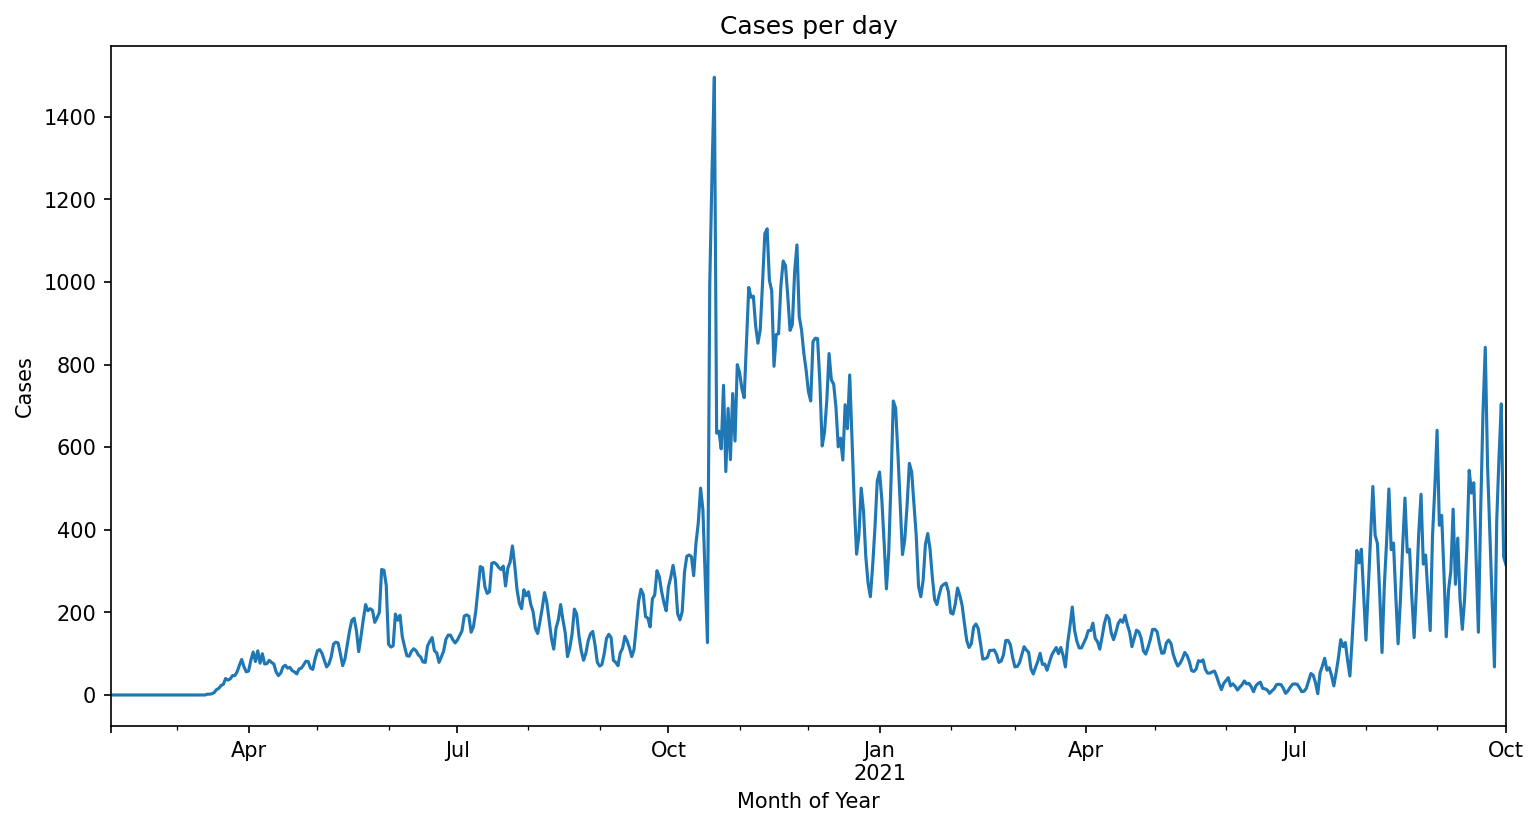

In [13]:
plt.figure(figsize=(12, 6), dpi=150)
df_main['cases'].plot()
plt.title('Cases per day')
plt.xlabel('Month of Year')
plt.ylabel('Cases')

# Save the plot as a png file
plt.savefig('/content/drive/MyDrive/MS Admission/Washington/GitHub/DataScienceProjects/data-512-project-common-analysis/plots/EDA/cases_per_day.png')

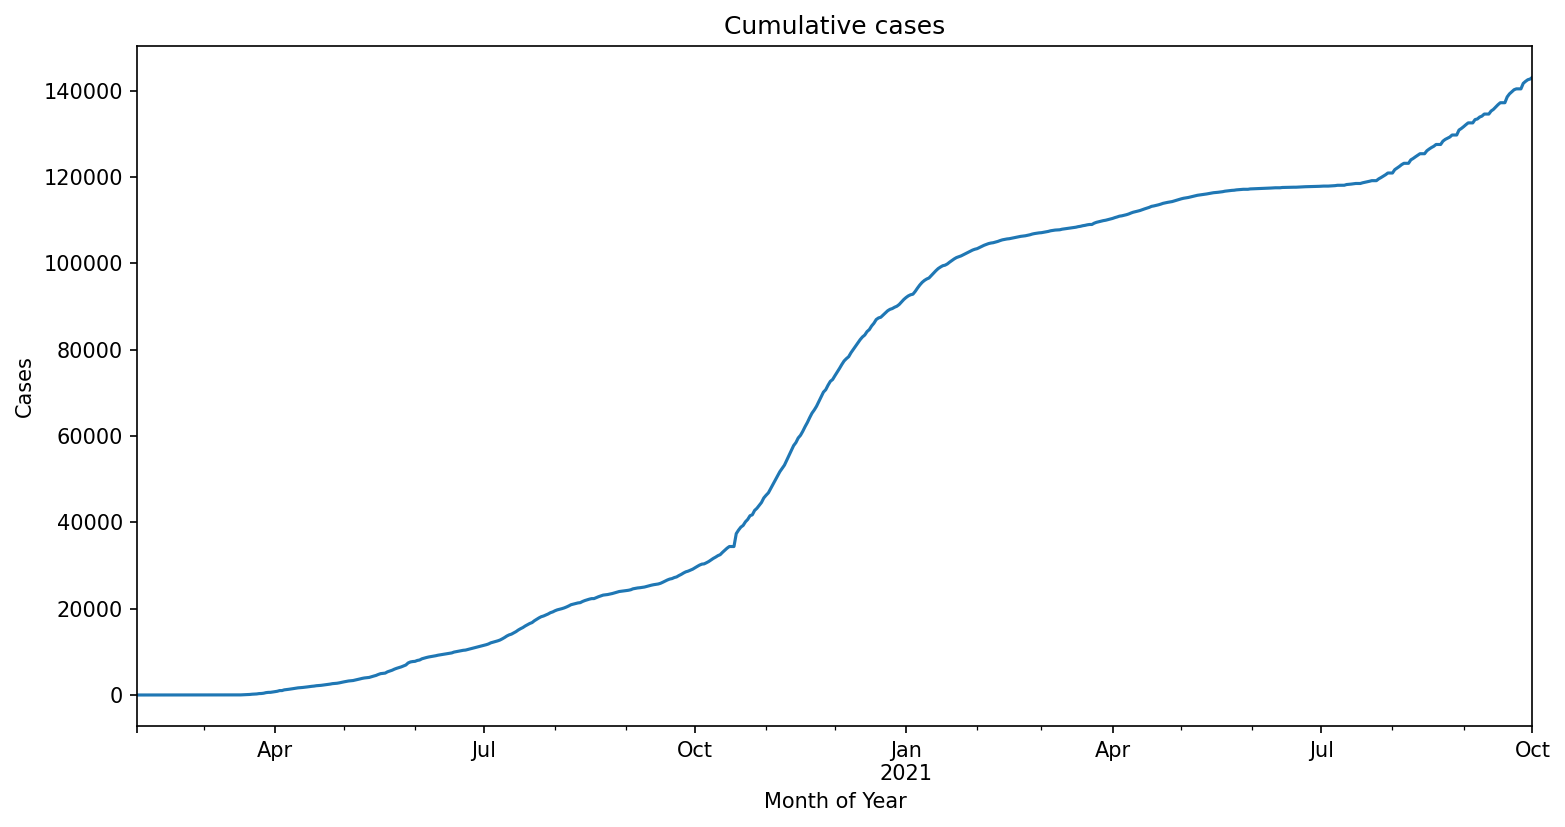

In [14]:
plt.figure(figsize=(12, 6), dpi=150)
df_main['cum_cases'].plot()
plt.title('Cumulative cases')
plt.xlabel('Month of Year')
plt.ylabel('Cases')

# Save the plot as a png file
plt.savefig('/content/drive/MyDrive/MS Admission/Washington/GitHub/DataScienceProjects/data-512-project-common-analysis/plots/EDA/cumulative_cases.png')

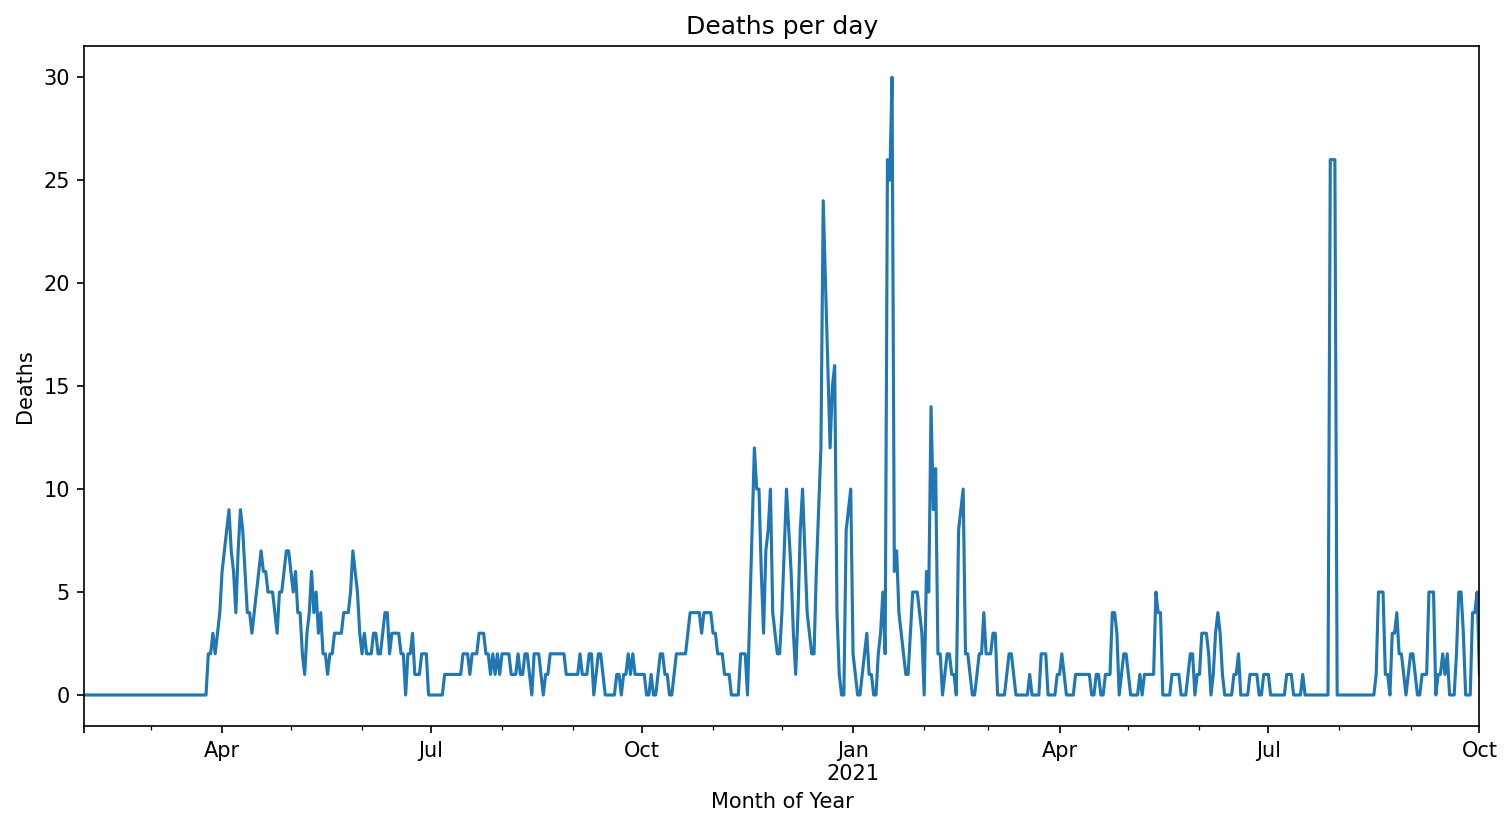

In [15]:
plt.figure(figsize=(12, 6), dpi=150)
df_main['deaths'].plot()
plt.title('Deaths per day')
plt.xlabel('Month of Year')
plt.ylabel('Deaths')

# Save the plot as a png file
plt.savefig('/content/drive/MyDrive/MS Admission/Washington/GitHub/DataScienceProjects/data-512-project-common-analysis/plots/EDA/deaths_per_day.png')

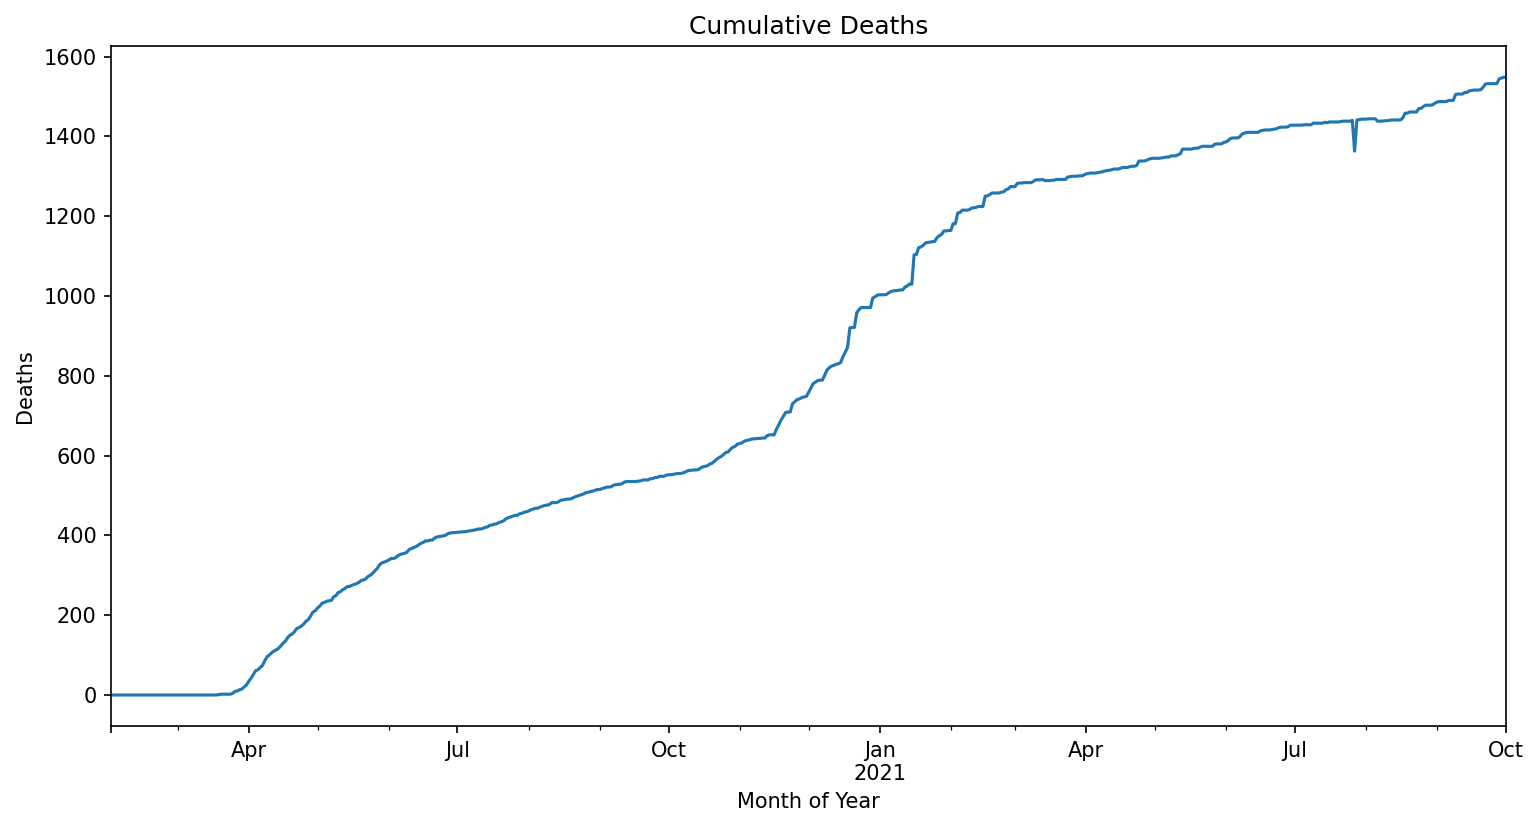

In [16]:
plt.figure(figsize=(12, 6), dpi=150)
df_main['cum_deaths'].plot()
plt.title('Cumulative Deaths')
plt.xlabel('Month of Year')
plt.ylabel('Deaths')

# Save the plot as a png file
plt.savefig('/content/drive/MyDrive/MS Admission/Washington/GitHub/DataScienceProjects/data-512-project-common-analysis/plots/EDA/cumulative_deaths.png')

### Visualize the mask mandate progression

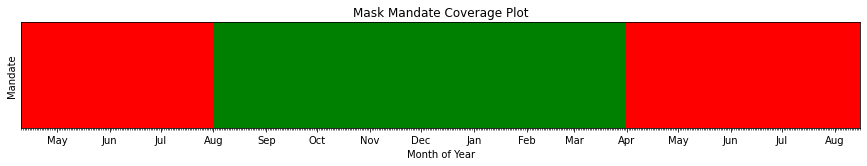

<Figure size 432x288 with 0 Axes>

In [17]:
holder = df_main['mask_required'].reset_index()

fig, ax= plt.subplots(figsize=(12,2))

# plot green for event:
s1 = holder[holder['mask_required'] == 'Yes']
inxval = matplotlib.dates.date2num(pd.to_datetime(s1.date))
times= list(zip(inxval, np.ones(len(s1))))
plt.broken_barh(times, (-1,1), color="green")

# plot red for event:
s2 = holder[holder['mask_required'] == 'No']
inxval = matplotlib.dates.date2num(pd.to_datetime(s2.date))
times= list(zip(inxval, np.ones(len(s2))))
plt.broken_barh(times, (-1,1), color="red")

ax.margins (0)
ax.set_yticks([])
ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator())
ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
monthFmt = matplotlib.dates.DateFormatter("%b")

ax. xaxis.set_major_formatter(monthFmt)

plt.tight_layout()
plt.title('Mask Mandate Coverage Plot')
plt.xlabel('Month of Year')
plt.ylabel('Mandate')
plt.show()

# Save the plot as a png file
plt.savefig('/content/drive/MyDrive/MS Admission/Washington/GitHub/DataScienceProjects/data-512-project-common-analysis/plots/mask_mandate_coverage.png')

# Step 2: Visualize

In this step we want you to create a graph that visualizes how the course of the disease was changed by masking policies. For your county, you should create a time series showing the changes in the derivative function of the rate of infection. Your graph should indicate days where masking policies were in effect (or not) and whether the difference in the derivative function was significant. Optionally, you can add a second time series that shows the actual rate of infection.


### Positive Cases Per Capita or Incidence Rate

Below is the logic used for spread category classification

Red: Uncontrolled substantial spread	15 or more cases

Orange: Controlled substantial spread	7 to 15 cases

Green: Low spread	Less than 7 cases

In [18]:
df_main['current_population'] = df_main['population'] - df_main['cum_deaths']
df_main['incidence_rate'] = df_main['cases'] * 100000 / df_main['current_population']
df_main['spread_category'] = np.where(df_main['incidence_rate'] >= 15, 'red' , np.where(df_main['incidence_rate'] >= 7, 'orange' , 'green'))

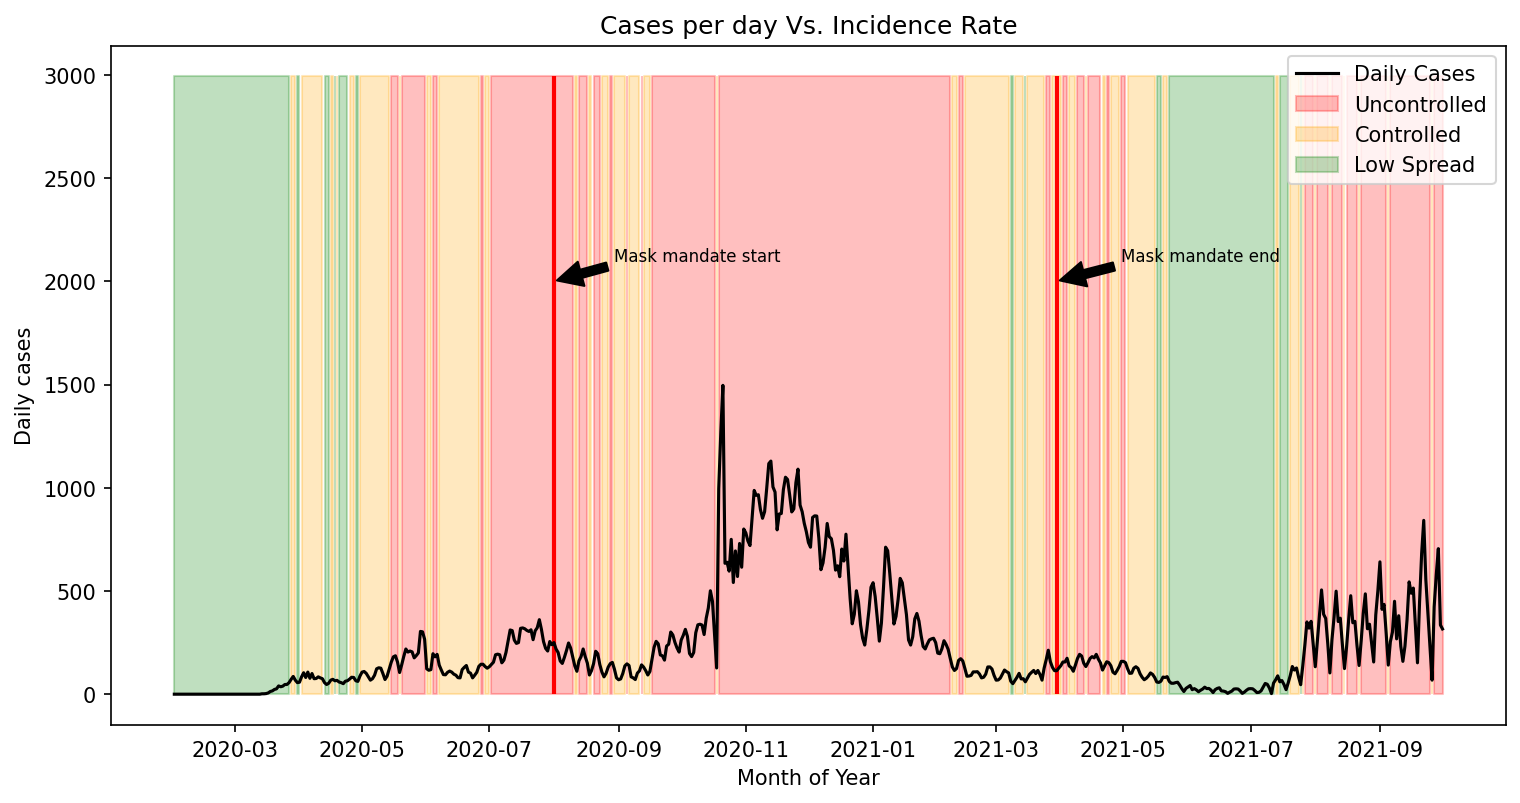

In [19]:
plt.figure(figsize=(12, 6), dpi=150)
y = df_main['cases']
x = df_main.index
z = df_main['spread_category']
plt.plot(x, y, color='black')

plt.fill_between(x, 0, 2*max(y), where = z == 'red', color='red', alpha=0.25)
plt.fill_between(x, 0, 2*max(y), where = z == 'orange', color='orange', alpha=0.25)
plt.fill_between(x, 0, 2*max(y), where = z == 'green', color='green', alpha=0.25)

#plt.axvline(x = pd.to_datetime('2020-08-01'), col)
plt.vlines(x = [pd.to_datetime('2020-08-01'), pd.to_datetime('2021-03-30')], ymin=[0, 0], ymax=[2*max(y), 2*max(y)], colors='red', ls='-', lw=2, label='Mask Mandate - Start to End')
plt.annotate('Mask mandate start', xy=(pd.to_datetime('2020-08-01'), 2000), xytext=(pd.to_datetime('2020-08-30'), 2100), fontsize = 8, arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('Mask mandate end', xy=(pd.to_datetime('2021-03-30'), 2000), xytext=(pd.to_datetime('2021-04-30'), 2100), fontsize = 8, arrowprops=dict(facecolor='black', shrink=0.05))

plt.title('Cases per day Vs. Incidence Rate')
plt.xlabel('Month of Year')
plt.ylabel('Daily cases')
plt.legend(['Daily Cases', 'Uncontrolled', 'Controlled', 'Low Spread'])

# Save the plot as a png file
plt.savefig('/content/drive/MyDrive/MS Admission/Washington/GitHub/DataScienceProjects/data-512-project-common-analysis/plots/cases_per_capita.png')

### Growth Factor

Growth factor is the change in confirmed cases today compared to the change yesterday. The number of confirmed cases is increasing in many days and there are two scenarios. Growth factor is larger than 1 and the number of cases is rapidly increasing or Growth factor is less than 1.

Where C is the number of confirmed cases,

Growth Factor=ΔCn / ΔCn−1

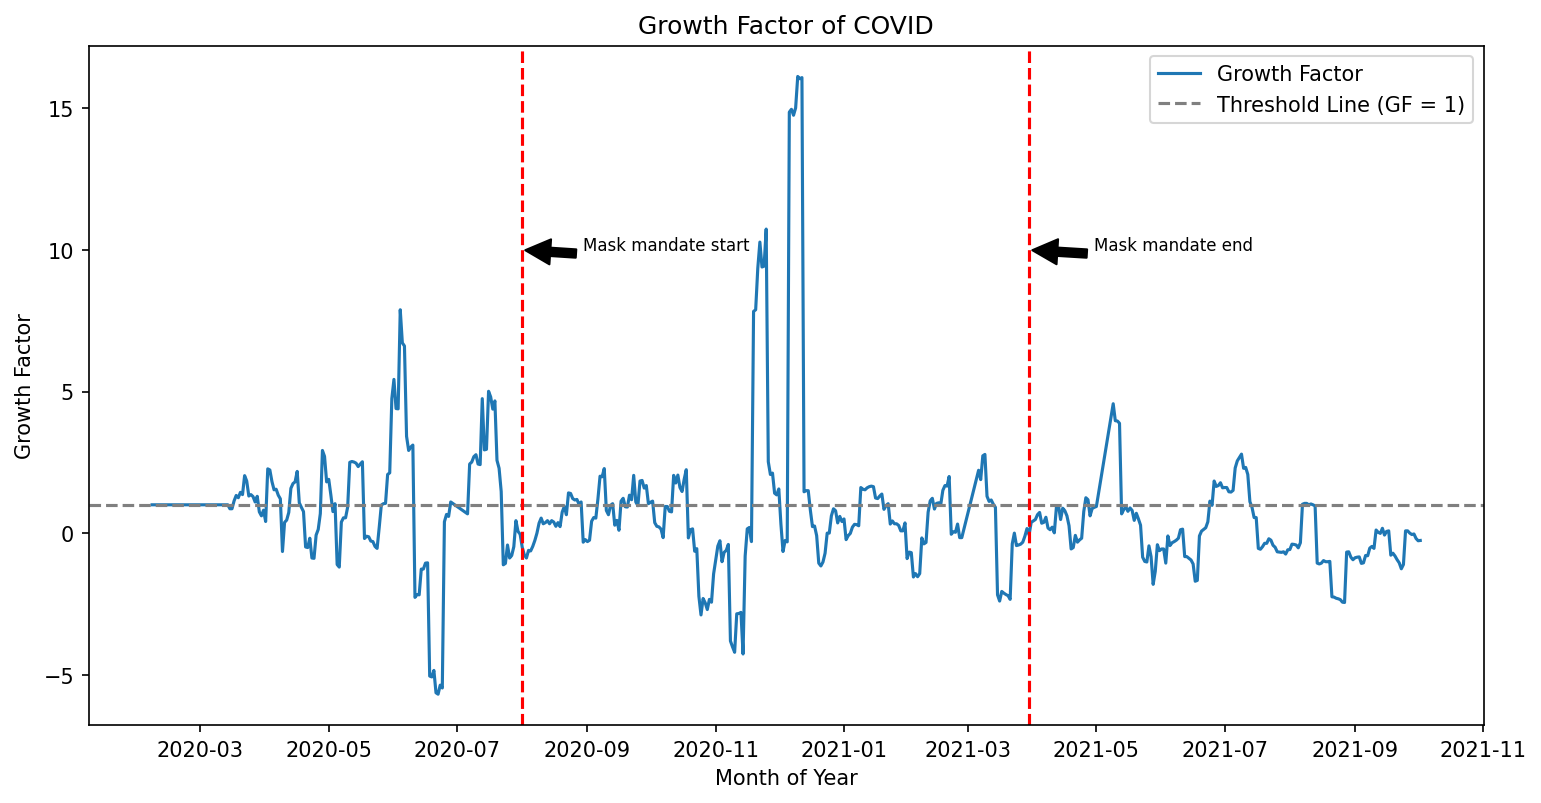

In [20]:
# Growth factor: (delta Number_n) / (delta Number_n)
df = df_main['cases']
df = df.diff() / df.diff().shift(freq="D")
df = df.replace(np.inf, np.nan).fillna(1.0)
# Rolling mean (window: 7 days)
df = df.rolling(7).mean().dropna()

plt.figure(figsize=(12, 6), dpi=150)
# round: 0.01
growth_value_df = df.round(2)
plt.plot(growth_value_df)

plt.axhline(y = 1, color = 'gray', linestyle = '--', label = 'Base Growth Factor (GF = 1)')
plt.axvline(x = pd.to_datetime('2020-08-01'), color = 'red', linestyle = '--', label = 'Mask Mandate Start')
plt.axvline(x = pd.to_datetime('2021-03-30'), color = 'red', linestyle = '--', label = 'Mask Mandate End')
plt.annotate('Mask mandate start', xy=(pd.to_datetime('2020-08-01'), 10), xytext=(pd.to_datetime('2020-08-30'), 10), fontsize = 8, arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('Mask mandate end', xy=(pd.to_datetime('2021-03-30'), 10), xytext=(pd.to_datetime('2021-04-30'), 10), fontsize = 8, arrowprops=dict(facecolor='black', shrink=0.05))
plt.title('Growth Factor of COVID')
plt.xlabel('Month of Year')
plt.ylabel('Growth Factor')

plt.legend(['Growth Factor', 'Threshold Line (GF = 1)'])

# Save the plot as a png file
plt.savefig('/content/drive/MyDrive/MS Admission/Washington/GitHub/DataScienceProjects/data-512-project-common-analysis/plots/growth_factor.png')

### Modeling the SIR

β(t)	Transmission or influence coefficient

α(t)	Per-capita recovery rate (its reciprocal is infectious period)

γ(t)	Per-capita rate of losing immunity or relapse rate

μ(t)	Per-capita mortality or departure rate

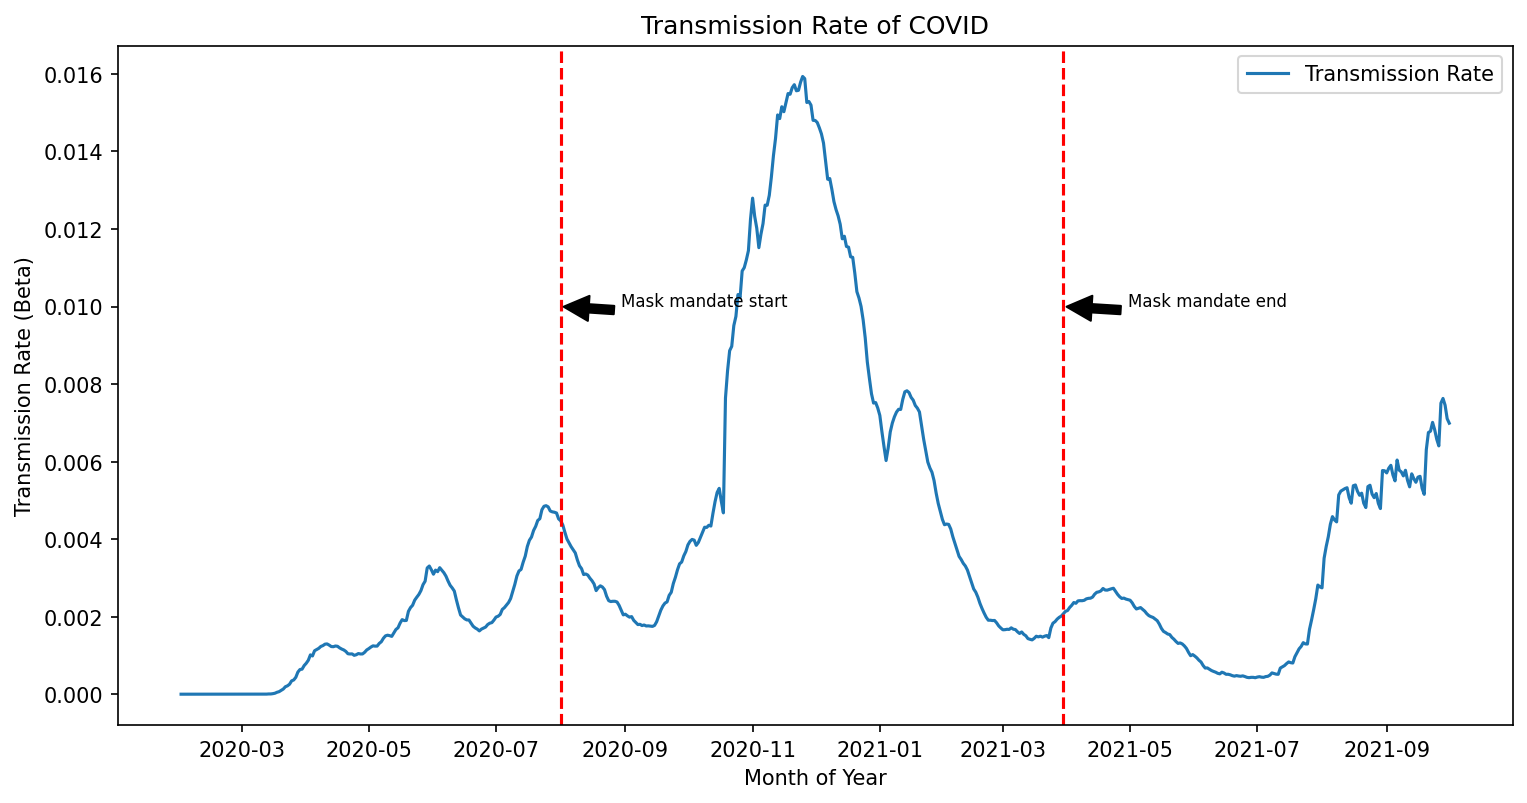

In [21]:
df_main['removed'] = df_main['cases']
df_main['removed'] = df_main['removed'].shift(14).fillna(0).astype('int64')
df_main['cum_removed'] = df_main['removed'].cumsum()
df_main['infected'] = df_main['cum_cases'] - df_main['cum_removed']

df_main['susceptible'] = df_main['population'] - df_main['infected'].shift(1) - df_main['removed'].shift(1)
df_main['susceptible'] = df_main['susceptible'].fillna(mwk_population)

df_main['transmission_rate'] = df_main['infected'] / df_main['susceptible']
df_main['infection_rate'] = df_main['cases'] * 100 / df_main['susceptible']
df_main['r0'] = df_main['transmission_rate'] / 0.07
plt.figure(figsize=(12, 6), dpi=150)
plt.plot(df_main['transmission_rate'])
plt.axvline(x = pd.to_datetime('2020-08-01'), color = 'red', linestyle = '--', label = 'Mask Mandate Start')
plt.axvline(x = pd.to_datetime('2021-03-30'), color = 'red', linestyle = '--', label = 'Mask Mandate End')
plt.annotate('Mask mandate start', xy=(pd.to_datetime('2020-08-01'), 0.01), xytext=(pd.to_datetime('2020-08-30'), 0.01), fontsize = 8, arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('Mask mandate end', xy=(pd.to_datetime('2021-03-30'), 0.01), xytext=(pd.to_datetime('2021-04-30'), 0.01), fontsize = 8, arrowprops=dict(facecolor='black', shrink=0.05))

plt.title('Transmission Rate of COVID')
plt.xlabel('Month of Year')
plt.ylabel('Transmission Rate (Beta)')

plt.legend(['Transmission Rate'])

# Save the plot as a png file
plt.savefig('/content/drive/MyDrive/MS Admission/Washington/GitHub/DataScienceProjects/data-512-project-common-analysis/plots/transmission_rate.png')

### Visualizing the change points

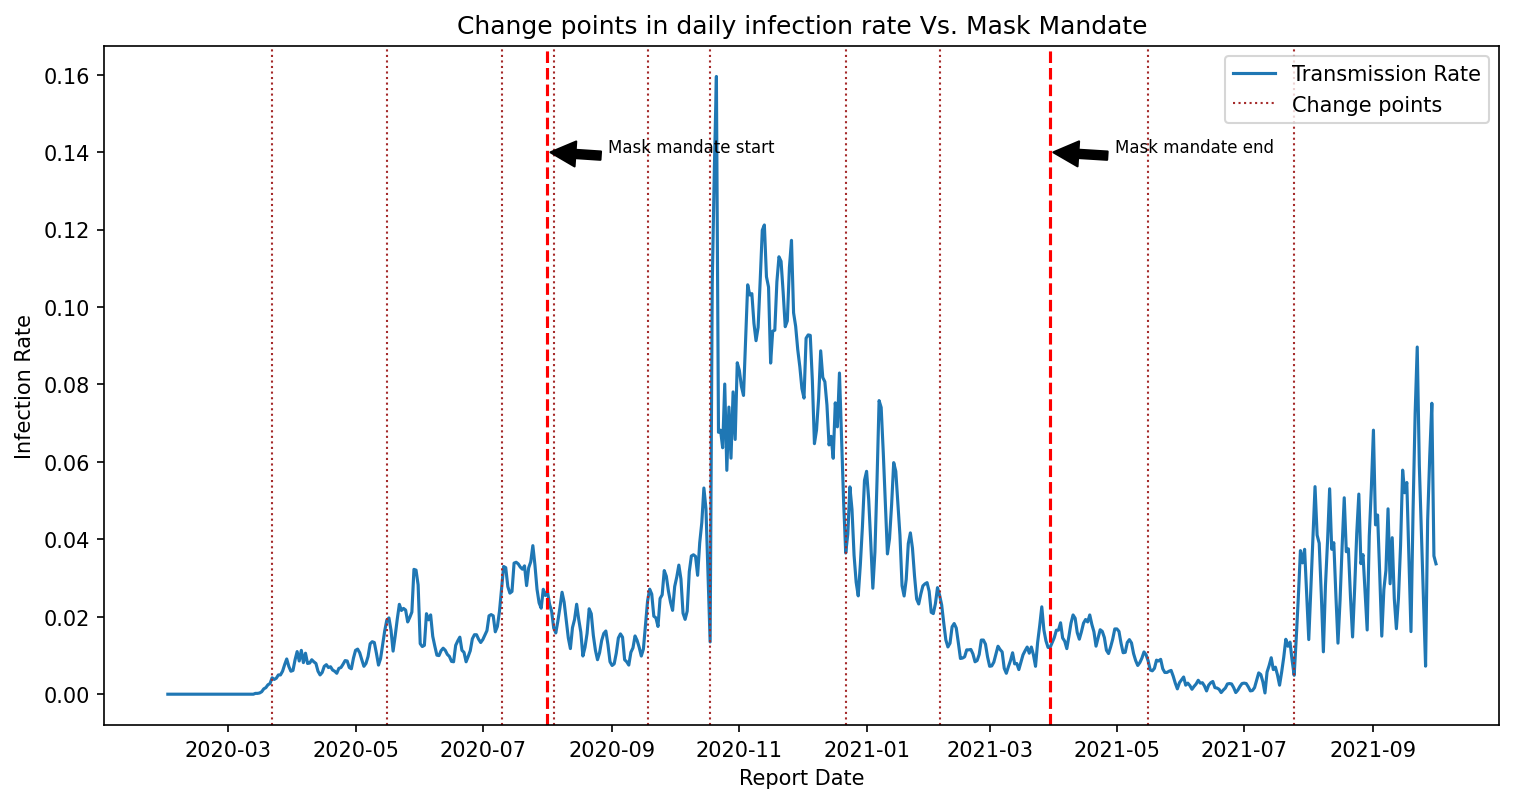

In [22]:
import ruptures as rpt
data = np.array(df_main['infection_rate'])

algo = rpt.Pelt(model="rbf").fit(data)
change_location = algo.predict(pen = 5)
change_location = df_main.iloc[change_location[:-1]].index.to_list()

plt.figure(figsize=(12, 6), dpi=150)
plt.plot(df_main['infection_rate'])
for x in change_location:
    plt.axvline(x, lw = 1, color = 'brown', linestyle = ':')

plt.axvline(x = pd.to_datetime('2020-08-01'), color = 'red', linestyle = '--', label = 'Mask Mandate Start')
plt.axvline(x = pd.to_datetime('2021-03-30'), color = 'red', linestyle = '--', label = 'Mask Mandate End')
plt.annotate('Mask mandate start', xy=(pd.to_datetime('2020-08-01'), 0.14), xytext=(pd.to_datetime('2020-08-30'), 0.14), fontsize = 8, arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('Mask mandate end', xy=(pd.to_datetime('2021-03-30'), 0.14), xytext=(pd.to_datetime('2021-04-30'), 0.14), fontsize = 8, arrowprops=dict(facecolor='black', shrink=0.05))
plt.title('Change points in daily infection rate Vs. Mask Mandate')
plt.xlabel('Report Date')
plt.ylabel('Infection Rate')

plt.legend(['Transmission Rate', 'Change points'])

# Save the plot as a png file
plt.savefig('/content/drive/MyDrive/MS Admission/Washington/GitHub/DataScienceProjects/data-512-project-common-analysis/plots/infection_rate.png')

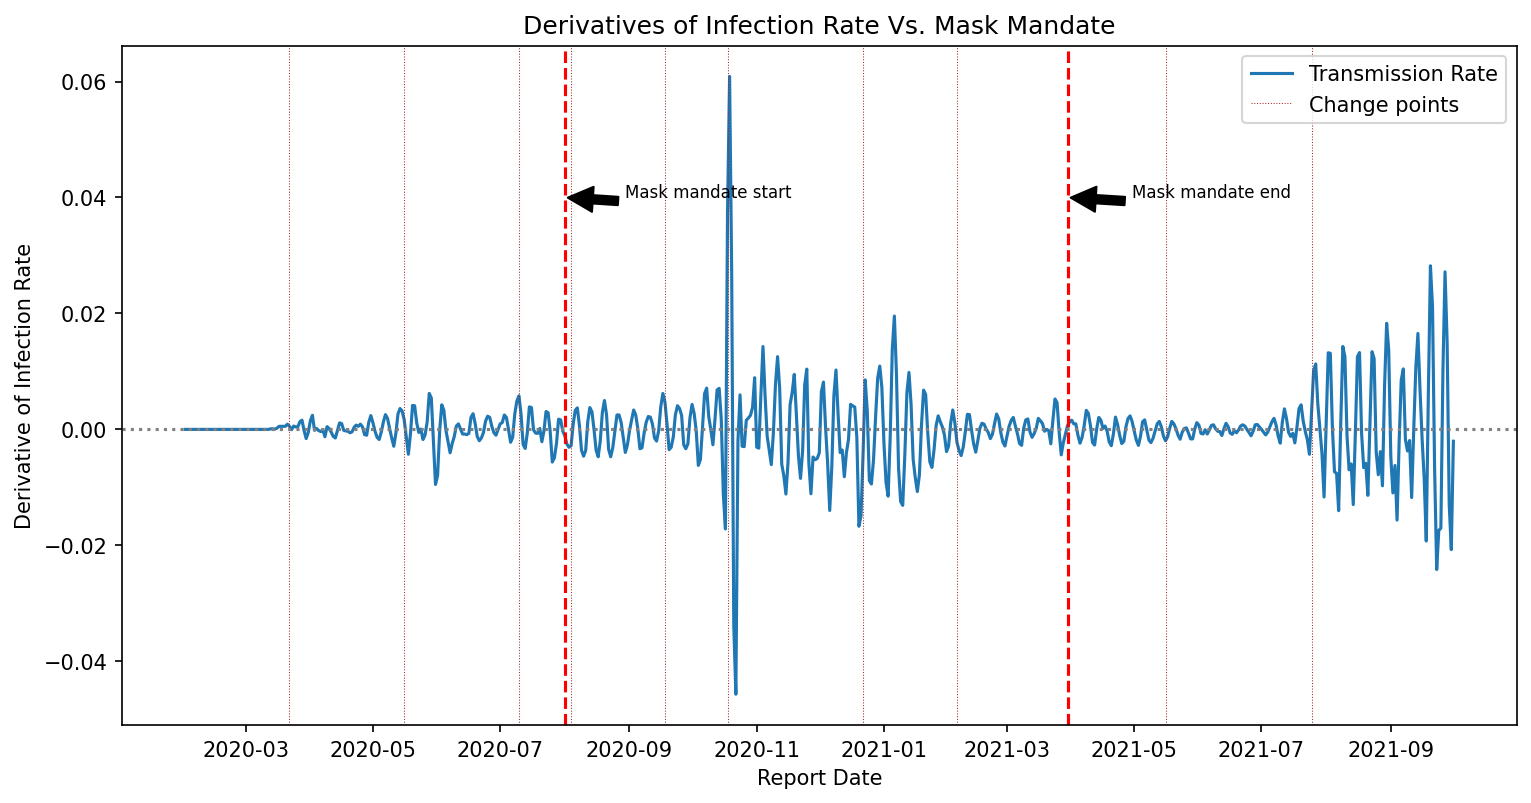

In [23]:
plt.figure(figsize=(12, 6), dpi=150)

df_main["derivative"] = pd.Series(np.gradient(df_main["infection_rate"]), df_main.index, name='derivative').values
plt.plot(df_main['derivative'])

for x in change_location:
    plt.axvline(x, lw = 0.5, color = 'brown', linestyle = ':')

plt.axhline(y = 0, color = 'gray', linestyle = ':', label = 'No change in infection rate')
plt.axvline(x = pd.to_datetime('2020-08-01'), color = 'red', linestyle = '--', label = 'Mask Mandate Start')
plt.axvline(x = pd.to_datetime('2021-03-30'), color = 'red', linestyle = '--', label = 'Mask Mandate End')
plt.annotate('Mask mandate start', xy=(pd.to_datetime('2020-08-01'), 0.04), xytext=(pd.to_datetime('2020-08-30'), 0.04), fontsize = 8, arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('Mask mandate end', xy=(pd.to_datetime('2021-03-30'), 0.04), xytext=(pd.to_datetime('2021-04-30'), 0.04), fontsize = 8, arrowprops=dict(facecolor='black', shrink=0.05))
plt.title('Derivatives of Infection Rate Vs. Mask Mandate')
plt.xlabel('Report Date')
plt.ylabel('Derivative of Infection Rate')

plt.legend(['Transmission Rate', 'Change points'])

# Save the plot as a png file
plt.savefig('/content/drive/MyDrive/MS Admission/Washington/GitHub/DataScienceProjects/data-512-project-common-analysis/plots/derivative_infection_rate.png')